**Note:** If you lanch it first time, so you don't have images in your Google Drive, run this:

In [1]:
# Unzip the uploaded data into Google Drive
# !unzip "/content/drive/My Drive/Makeup/makeup-or-no-makeup.zip" -d "/content/drive/My Drive/Makeup/"

# Makeup or No Makeup


Can you determine which person is wearing makeup?

This notebook is a guide will help you train a neural network that classifies images (True or False). For example, we'll classify whether or not person on image having makeup.

## 1. Problem

Using Tensorflow, determine if there is makeup or no.

## 2. Data

The data we're using is from Kaggle : https://www.kaggle.com/petersunga/make-up-vs-no-make-up

## 3. Evaluation

The evaluation is a prediction of probabilities having makeup for each image.

## 4. Features

Some information about the data:

* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* 1062 images of people wearing makeup
* 444 images of people not wearing makeup

### Get our workspace ready

* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU

**Note:** For GPU :
Edit > Notebook settings or Runtime>Change runtime type and select GPU as Hardware accelerator.

In [2]:
# Import TensorFlow into Colab
import tensorflow as tf
print("TF version:", tf.__version__)
# Import TensorFlow Hub into Colab
import tensorflow_hub as hub
print("TF Hub version:", hub.__version__)
# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.3.0
TF Hub version: 0.9.0
GPU available


**Preparing the tools:**
* pandas for data analysis
* NumPy for numerical operations
* Matplotlib/seaborn for plotting of data visualization

In [3]:
# Regular EDA and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# data parsing
from sklearn.utils import shuffle
# convert images
from matplotlib.pyplot import imread
# view image
import IPython.display as display
# split data
from sklearn.model_selection import train_test_split

## Preparing datasets

Our data is divided into two folders:
* makeup
* no makeup

So, we need to load images and create labels, which equals 1 if the person on image has makeup and 0 if doesn't have.

To make this, we'll:
* load all images path (makeup and no makeup) and create labels
* create a common dataframe which contains filepaths from both folders and labels
* shuffle a dataframe
* create X & y variables 

### Filepaths and labels

In [4]:
# load image path using os
import os

# path to folders
makeup_directory = "/content/drive/My Drive/Makeup/makeup-or-no-makeup/makeup/"
no_makeup_directory = "/content/drive/My Drive/Makeup/makeup-or-no-makeup/no_makeup/"

# create a lists with filenames
makeup_filenames = [makeup_directory + file for file in os.listdir(makeup_directory)]
no_makeup_filenames = [no_makeup_directory + file for file in os.listdir(no_makeup_directory)]

In [5]:
# check lists
makeup_filenames[:2], no_makeup_filenames[:2]

(['/content/drive/My Drive/Makeup/makeup-or-no-makeup/makeup/makeup4.jpeg',
  '/content/drive/My Drive/Makeup/makeup-or-no-makeup/makeup/makeup256.jpeg'],
 ['/content/drive/My Drive/Makeup/makeup-or-no-makeup/no_makeup/no_makeup262.jpeg',
  '/content/drive/My Drive/Makeup/makeup-or-no-makeup/no_makeup/no_makeup384.jpeg'])

In [6]:
# create labels
# [x, y] - x - probability of having makeup
#          y - probability of not having makeup
# 1 - having makeup, 0 - not having makeup
label_makeup = [(1, 0) for i in range(len(makeup_filenames))]
label_no_makeup = [(0, 1) for i in range(len(no_makeup_filenames))]

In [7]:
# combine the data
filenames = np.concatenate([makeup_filenames, no_makeup_filenames])
labels = np.concatenate([label_makeup, label_no_makeup])

### Common dataframe

In [8]:
# create a data frame with all filnames and labels
df = pd.DataFrame(filenames, columns=["Filenames"])
df[["Makeup", "No Makeup"]] = labels
df.head()

,Filenames,Makeup,No Makeup
0,/content/drive/My Drive/Makeup/makeup-or-no-ma...,1,0
1,/content/drive/My Drive/Makeup/makeup-or-no-ma...,1,0
2,/content/drive/My Drive/Makeup/makeup-or-no-ma...,1,0
3,/content/drive/My Drive/Makeup/makeup-or-no-ma...,1,0
4,/content/drive/My Drive/Makeup/makeup-or-no-ma...,1,0


### Shuffle data frame

In [9]:
# to get combined data, let's shuffle dataframe
df = shuffle(df)
df.head()

,Filenames,Makeup,No Makeup
159,/content/drive/My Drive/Makeup/makeup-or-no-ma...,1,0
307,/content/drive/My Drive/Makeup/makeup-or-no-ma...,1,0
726,/content/drive/My Drive/Makeup/makeup-or-no-ma...,1,0
743,/content/drive/My Drive/Makeup/makeup-or-no-ma...,1,0
391,/content/drive/My Drive/Makeup/makeup-or-no-ma...,1,0


### Create X & y variables

Our X data is images, y is labels.

Before, we need to convert images to numerical arrays. Let's use Tensors. So, our tasks:
* create a function to convert one image to tensor
* create a function to turn all data (images and labels) into batches

#### Convert images to Tensors


In [10]:
# Define image size
IMG_SIZE = 224

# create a function to convert image to tensor
def convert_image_to_tensor(img_path, img_size=IMG_SIZE):
  """
  Convert image to tensor.
  image : full path to image
  img_size : required image size for using model
  """
  # take an image from image path
  img_raw = tf.io.read_file(img_path)
  # convert it to an image tensor with 3 colour channels (Red, Green, Blue)
  img_tensor = tf.image.decode_jpeg(img_raw, channels=3)
  # change size for using model
  img_final = tf.image.resize(img_tensor, size=[img_size, img_size])
  # convert the colour channel values from 0-255 to 0-1 values
  img_final = img_final/255.0
  return img_final

In [11]:
# check convert_image_to_tensor()
convert_image_to_tensor(df['Filenames'][42])[:2]

<tf.Tensor: shape=(2, 224, 3), dtype=float32, numpy=
array([[[0.84314597, 0.8902048 , 0.84314597],
        [0.8470501 , 0.8941089 , 0.8470501 ],
        [0.84705013, 0.89410895, 0.84705013],
        ...,
        [0.6042279 , 0.3964286 , 0.19228804],
        [0.635119  , 0.4272759 , 0.21558112],
        [0.6548406 , 0.43918937, 0.22742471]],

       [[0.8431109 , 0.8902223 , 0.8431372 ],
        [0.8430847 , 0.8901961 , 0.843111  ],
        [0.84312814, 0.89023954, 0.84315443],
        ...,
        [0.623765  , 0.41606197, 0.21189512],
        [0.6508494 , 0.4430588 , 0.23911093],
        [0.64704156, 0.43925092, 0.22752996]]], dtype=float32)>

Let's check a few images.

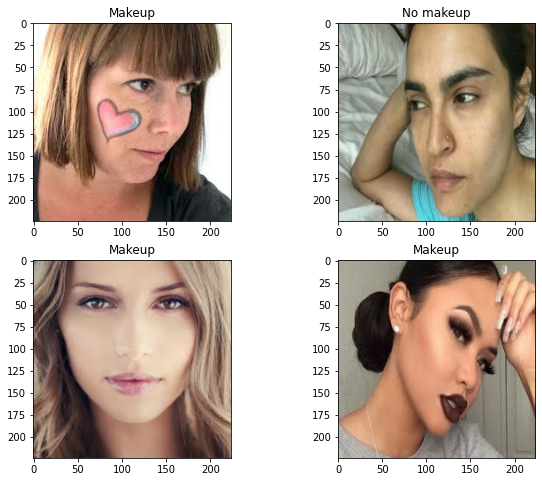

In [12]:
plt.figure(figsize=(10, 8))
for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  index = np.random.randint(0, len(df)-1)
  plt.imshow(convert_image_to_tensor(df['Filenames'][index]))
  if df['Makeup'][index] == 1:
    title = "Makeup"
  else:
    title = "No makeup"
  plt.title(title)

#### Convert data to batches

We need to convert all data into bathes to ensure that the data will fit in memory. So, define : 

> batch size - number of images at a time

**Note:**
* To use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this : `(image, label)`.
* To create dataset, we'll use `from_tensor_slices()`

In [13]:
# create a simple function to return a tuple (image, label)
def get_image_label(path, label):
  """
  Takes an image file path name and the assosciated label, 
  processes the image and returns a typle of (image, label).
  """
  return convert_image_to_tensor(path), label

In [14]:
# example of function's get_image_label work
get_image_label(df['Filenames'][25], [df['Makeup'][25], df['No Makeup'][25]])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.9328869 , 0.968181  , 0.96425945],
         [0.9328869 , 0.968181  , 0.96425945],
         [0.93714106, 0.9660539 , 0.96425945],
         ...,
         [0.9490196 , 0.9490196 , 0.9490196 ],
         [0.9490196 , 0.9490196 , 0.9490196 ],
         [0.9490196 , 0.9490196 , 0.9490196 ]],
 
        [[0.9307511 , 0.9620273 , 0.9567665 ],
         [0.9307511 , 0.9620273 , 0.9567665 ],
         [0.9335524 , 0.9606267 , 0.9567665 ],
         ...,
         [0.9490196 , 0.9490196 , 0.9490196 ],
         [0.9490196 , 0.9490196 , 0.9490196 ],
         [0.9490196 , 0.9490196 , 0.9490196 ]],
 
        [[0.93333334, 0.9523984 , 0.9467875 ],
         [0.93171406, 0.9540178 , 0.9467875 ],
         [0.9311012 , 0.9522091 , 0.9455767 ],
         ...,
         [0.9490196 , 0.9490196 , 0.9490196 ],
         [0.9490196 , 0.9490196 , 0.9490196 ],
         [0.9490196 , 0.9490196 , 0.9490196 ]],
 
        ...,
 
        [[0.9607843 , 0.9607843 

For fitting our model, we need:
* well-mixed data
* packed data

That's why we need to shuffle train data, but we don't need do this with test data. To add these properties, we'll use `tf.data` api.

In [15]:
# Define a batch size
BATCH_SIZE = 50

# create a function to turn all data (images and labels) into batches
def create_data_batch(X, y=None, batch_size=BATCH_SIZE, test_data=False):
  """
  Turn all data (images (X) and labels (y)) into batches.
  Shuffles the data if it's training data.
  Also accepts test data as input (no labels).
  X : list of filepaths
  y : list of labels
  batch_size : int
  test_data : True or False (default)
  """
  # if the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    # build a slice of data 
    data = tf.data.Dataset.from_tensor_slices((X))
    # convert image into tensor 
    data = data.map(convert_image_to_tensor)
    # setting the size of the shuffle buffer equal to the data set 
    # guarantees complete mixing of data
    data = data.shuffle(buffer_size=len(X))
    # data = data.repeat()
    # pack data
    data = data.batch(batch_size)
    # prefetch() allows the dataset to extract packets in the background, while training the model
    data = data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    print("Create!")
    return data
  # if the data is a train dataset
  else:
    print("Creating training data batches...")
    # build a slice of data 
    data = tf.data.Dataset.from_tensor_slices((X, y))
    # convert image into tensor and return all data as pair (image, labels)
    data = data.map(get_image_label)
    # setting the size of the shuffle buffer equal to the data set 
    # guarantees complete mixing of data
    data = data.shuffle(buffer_size=len(X))
    # data = data.repeat()
    # pack data
    data = data.batch(batch_size)
    # prefetch() allows the dataset to extract packets in the background, while training the model
    data = data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    print("Create!")
    return data

### Creating datasets

In [16]:
# now we can create X and y variables
X = df['Filenames']
y = [[df['Makeup'][i], df['No Makeup'][i]] for i in range(len(df))]
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# turn data into batches
train_data = create_data_batch(X_train, y_train)
test_data = create_data_batch(X_test, test_data=True)

Creating training data batches...
Create!
Creating test data batches...
Create!


In [17]:
# check creating datasets
train_data.element_spec, test_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.int32, name=None)),
 TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None))

## Modeling

### Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (our images shape, in the form of Tensors) to our model.
* The URL of the model we want to use from TensorFlow Hub : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4.



In [18]:
# setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #batch, height, width, colour channels

# setup outnput shape of our model (1 or 0)
OUTPUT_SHAPE = 2

# setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Let's build sequential model, because it's suitable for a simple set of layers, where each layer has exactly one input tensor and one output tensor.

In [19]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with :", model_url)

  # Setup the model layers
  model = tf.keras.Sequential([
        hub.KerasLayer(model_url), # Layer 1 (input)
        # output_shape - what shape we want to see in results
        tf.keras.layers.Dense(units=output_shape, activation="softmax") # Layer 2 (output)                       
  ])

  # Compile model
  model.compile(
      # loss = 0 in perfect case - how well model guessing
      loss = tf.keras.losses.CategoricalCrossentropy(),
      # function which helps to model improve it's guessing
      optimizer=tf.keras.optimizers.Adam(),
      # way of evaluating those guesses
      metrics=["accuracy"]
  )

  # Build the model
  model.build(input_shape)

  return model

Compile the model to describe the learning process.

In [20]:
model = create_model()
model.summary()

Building model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 2)                 2004      
Total params: 5,434,717
Trainable params: 2,004
Non-trainable params: 5,432,713
_________________________________________________________________


### Training a model

Now we are ready to train the model. Let's create a function which trains a model.

* Create a model using `create_model()`
* Call the `fit()` function on our model passing it in the training data, number of epochs to train for (`NUM_EPOCHS`) and the create callbacks we'd like to use
* Return the model

In [140]:
NUM_EPOCHS = 100 #@param {type:"slider", min:50, max:150, step:1}

In [141]:
# build a function to train and return a trained model
def train_model(train_data):
  """
  Trains a given model and returns the trainded version.
  """
  # create a model
  model = create_model()

  # fit the model
  model.fit(x=train_data, 
            epochs=NUM_EPOCHS, 
            verbose=1)
  # return the fitted model
  return model

In [142]:
# fit the model to the data
model = train_model(train_data)

Building model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 2s 72ms/step - loss: 0.9870 - accuracy: 0.5972
Epoch 2/100
25/25 [==============================] - 2s 72ms/step - loss: 0.7435 - accuracy: 0.6586
Epoch 3/100
25/25 [==============================] - 2s 72ms/step - loss: 0.6811 - accuracy: 0.6503
Epoch 4/100
25/25 [==============================] - 2s 73ms/step - loss: 0.6326 - accuracy: 0.6844
Epoch 5/100
25/25 [==============================] - 2s 72ms/step - loss: 0.6194 - accuracy: 0.7101
Epoch 6/100
25/25 [==============================] - 2s 73ms/step - loss: 0.6042 - accuracy: 0.6869
Epoch 7/100
25/25 [==============================] - 2s 72ms/step - loss: 0.5782 - accuracy: 0.7226
Epoch 8/100
25/25 [==============================] - 2s 72ms/step - loss: 0.5850 - accuracy: 0.7193
Epoch 9/100
25/25 [==============================] - 2s 72ms/step - loss: 0.5759 - accuracy: 0.7209
Epoch 

## Making and evaluating predictions using a trained model

In [143]:
# make predictions on the test data (not used to train on)
predictions = model.predict(test_data, verbose=1)
predictions[:10]

2/7 [=======>......................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0172s vs `on_predict_batch_end` time: 0.0580s). Check your callbacks.


7/7 [==============================] - 0s 63ms/step


array([[0.7680456 , 0.23195438],
       [0.83802027, 0.16197978],
       [0.41228   , 0.58772004],
       [0.72141725, 0.27858272],
       [0.98942333, 0.0105767 ],
       [0.98158526, 0.01841479],
       [0.9551434 , 0.04485657],
       [0.6491872 , 0.3508128 ],
       [0.89937896, 0.10062104],
       [0.9856602 , 0.01433979]], dtype=float32)

In [144]:
# create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of images Tensors and returns separate arrays
  of images.
  """
  images = []
  # Loop through unbatched data
  for image in data.unbatch().as_numpy_iterator():
    images.append(image)
  return images

In [145]:
# Unbatchify the test data
test_images = unbatchify(test_data)
test_images[0]

array([[[0.40149686, 0.41326156, 0.3849177 ],
        [0.34567577, 0.3534226 , 0.31946778],
        [0.363139  , 0.35867473, 0.31837362],
        ...,
        [0.57200617, 0.5428658 , 0.468356  ],
        [0.5764706 , 0.54509807, 0.47058824],
        [0.5764706 , 0.54509807, 0.47058824]],

       [[0.37938547, 0.39050245, 0.36248246],
        [0.32860646, 0.33260664, 0.30052513],
        [0.36712056, 0.3626563 , 0.32235518],
        ...,
        [0.59638464, 0.5684698 , 0.49396   ],
        [0.5992297 , 0.5707021 , 0.49619222],
        [0.6017506 , 0.5707021 , 0.49619222]],

       [[0.37952554, 0.3866275 , 0.36061507],
        [0.32484323, 0.32742548, 0.29605293],
        [0.3625405 , 0.35807624, 0.3177751 ],
        ...,
        [0.6311361 , 0.60793936, 0.53342956],
        [0.6333683 , 0.61017156, 0.53566176],
        [0.6368434 , 0.6082867 , 0.53566176]],

       ...,

       [[0.22410427, 0.208418  , 0.16528073],
        [0.23195922, 0.2109158 , 0.16777855],
        [0.24895562, 0

In [146]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  prediction_probabilities: ndarray of predictions made by model
  labels : list of y_test values
  images : list of unbatched test images
  """
  pred_prob, true_prob, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = "MakeUp" if pred_prob[0] * 100 > 50 else "No MakeUp"
  # Get the true label
  true_label = "MakeUp" if true_prob == [1, 0] else "No MakeUp"

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is wright or wrong
  if pred_label == true_label:
    colour = "green"
  else:
    colour = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label, np.max(pred_prob) * 100, true_label), color=colour)

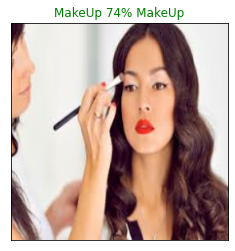

In [147]:
# check plot_pred() function
plot_pred(predictions, y_test, test_images, n=49)

In [148]:
# create a function to view predictions
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus prediction confidences along with the truth label for sample n.
  prediction_probabilities: ndarray of predictions made by model
  labels : list of y_test values
  """
  pred_prob, true_prob = prediction_probabilities[n], labels[n]

  # Get the pred label
  pred_label = "MakeUp" if pred_prob[0] * 100 > 50 else "No MakeUp"
  # Get the true label
  true_label = "MakeUp" if true_prob == [1, 0] else "No MakeUp"

  values = pred_prob
  labels = ["MakeUp", "No MakeUp"]

  # Plot image & remove ticks
  top_plot = plt.bar(np.arange(len(labels)),
                     values, 
                     color="grey")
  plt.xticks(np.arange(len(labels)), labels=labels, rotation='horizontal')

  # change the colour of wright probability
  if true_label == "MakeUp":
    top_plot[0].set_color("green")
  else:
    top_plot[1].set_color("green")

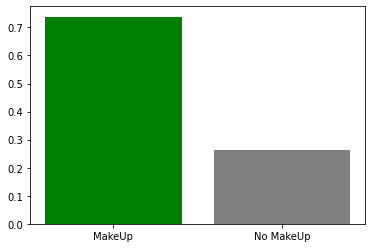

In [149]:
# check plot_pred_conf() function
plot_pred_conf(predictions, y_test, n=49)

Check out a few predictions and their different values

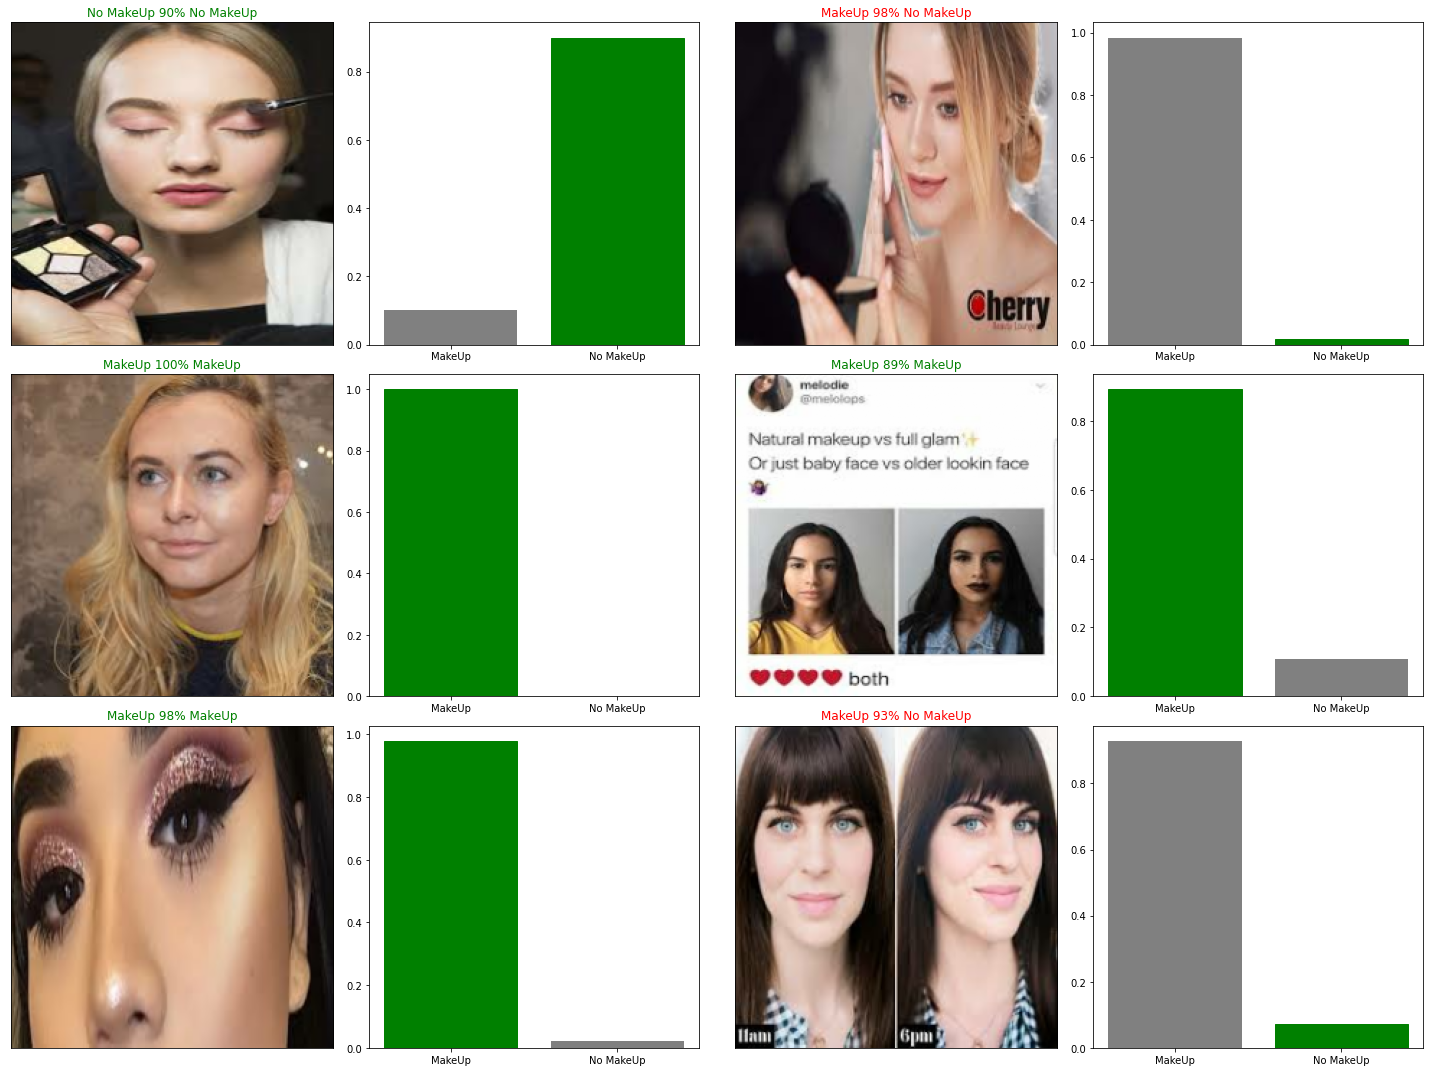

In [150]:
i_multiplier = 10
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10 * num_cols, 5 * num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(predictions, y_test, test_images, i + i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(predictions, y_test, i + i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Making predicions on custom images

To make prediciton on custom images, we'll:
* Get the filepath of our own images.
* Turn the filepath into data batches using `create_data_butches()`.
* Pass the custom image fata batch to our model's `predict()` method.
* Convert the prediction output probabilities to predictions labels.
* Copmare the predicted labels to the custon images.

In [163]:
# get custom image filenames
custom_path = "/content/drive/My Drive/Makeup/check-photo/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_image_paths

['/content/drive/My Drive/Makeup/check-photo/photo1.jpg',
 '/content/drive/My Drive/Makeup/check-photo/photo2.jpg',
 '/content/drive/My Drive/Makeup/check-photo/photo3.jpg',
 '/content/drive/My Drive/Makeup/check-photo/photo4.jpeg']

In [164]:
# turn custom images into batch dataset
custom_data = create_data_batch(custom_image_paths, test_data=True)
custom_data

Creating test data batches...
Create!


<PrefetchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [165]:
# make predictions on the custom data
custom_preds = model.predict(custom_data, verbose=1)
custom_preds

1/1 [==============================] - 0s 7ms/step


array([[0.3943394 , 0.60566056],
       [0.7109389 , 0.28906116],
       [0.17636342, 0.8236366 ],
       [0.14511058, 0.85488945]], dtype=float32)

In [166]:
# get custom images 
custom_images = []
# loop throug unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

In [167]:
# convert predictions into labels
custom_preds_labels = ["MakeUp" if custom_preds[i][0] > 0.5 else "No MakeUp" for i in range(len(custom_preds))]
custom_preds_labels

['No MakeUp', 'MakeUp', 'No MakeUp', 'No MakeUp']

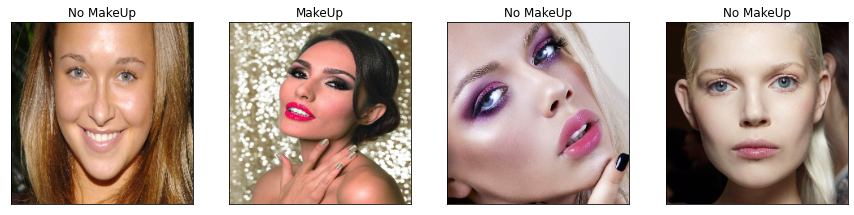

In [168]:
# check custom image predictions
plt.figure(figsize=(15, 15))
for i, image in enumerate(custom_images):
  plt.subplot(1, 4, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_preds_labels[i])
  plt.imshow(image)